In [1]:
import os
import time
import xarray as xr
import rioxarray as rxr
from rasterio.enums import Resampling
from rasterio import Affine
from urllib.request import urlretrieve
from osgeo import gdal, osr
import numpy as np
import cftime as cf
import datetime

In [2]:
# vars
sdate = datetime.datetime(2020, 1, 1)
edate = datetime.datetime(2050, 1, 1)

# data sources
remote_data = 'https://www.arcgis.com/sharing/rest/content/items/f950ea7878e143258a495daddea90cc0/data'
local_data = 'sequestration_rate_mean_aboveground_full_extent_Mg_C_ha_yr.tif'
remote_u_data = 'https://www.arcgis.com/sharing/rest/content/items/d28470313b8e443aa90d5cbcd0f74163/data'
local_u_data = 'sequestration_error_ratio_layer_in_full_extent.tif'

In [107]:
# Open the input raster
download_stamp = time.strftime('%Y-%m-%d', time.localtime(os.path.getmtime(local_data)))
if not os.path.isfile(local_data):
    urlretrieve(remote_data, local_data)
data = rxr.open_rasterio(local_data)

# ensure data is not projected and is wgs84
epsg_code = int(data.rio.crs.to_epsg())
if epsg_code != 4326:
    data = data.rio.reproject(crs='EPSG:4326')

In [108]:
# resample to 0.5 degrees using bilinear interpolation
target_res = 0.5
data = data.rio.write_nodata(np.nan, inplace=True)
resampled_data = data.coarsen(band=1, 
                              x=(int((data.rio.height * abs(data.rio.resolution()[0])) / target_res)),
                              y=(int((data.rio.width * abs(data.rio.resolution()[0])) / target_res))
                             ).mean()

In [109]:
ds = resampled_data.rename({'x': 'lon', 'y': 'lat'})

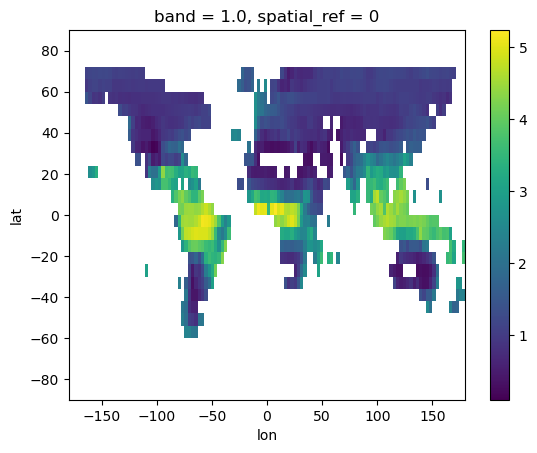

In [110]:
ds.plot()

In [111]:
tb_arr = np.asarray([
    [cf.DatetimeNoLeap(sdate.year, sdate.month, sdate.day)],
    [cf.DatetimeNoLeap(edate.year, edate.month, edate.day)]
]).T

In [112]:
tb_da = xr.DataArray(tb_arr, dims=('time', 'nv'))

In [113]:
ds = ds.expand_dims(time=tb_da.mean(dim='nv'))

In [114]:
# is this right?
ds.time.attrs['bounds'] = tb_da

In [115]:
ds.time.attrs

{'time_bnds': <xarray.DataArray (time: 1, nv: 2)> Size: 16B
 array([[cftime.DatetimeNoLeap(2020, 1, 1, 0, 0, 0, 0, has_year_zero=True),
         cftime.DatetimeNoLeap(2050, 1, 1, 0, 0, 0, 0, has_year_zero=True)]],
       dtype=object)
 Dimensions without coordinates: time, nv}